In [1]:
from operator import itemgetter, attrgetter
import json

with open('./one_epoch_models.json') as f:
    models_params_data = json.load(f)

In [2]:
print(len(models_params_data))

models_params_data[0]

[0.994,
 {'conv_layers': [{'in_channels': 1, 'out_channels': 8, 'kernel_size': 5},
   {'in_channels': 8, 'out_channels': 16, 'kernel_size': 5}],
  'regular_layers': [256, 128, 64, 10],
  'activation_function': 'Swish',
  'optimizer': 'SGD',
  'criterion': 'CrossEntropy',
  'learning_rate': 0.1,
  'momentum': 0.5}]

In [43]:
show_top = 3
for i in range(0, show_top):
    print((models_params_data[i][1]))

{'conv_layers': [{'in_channels': 1, 'out_channels': 8, 'kernel_size': 5}, {'in_channels': 8, 'out_channels': 16, 'kernel_size': 5}], 'regular_layers': [256, 128, 64, 10], 'activation_function': 'Swish', 'optimizer': 'SGD', 'criterion': 'CrossEntropy', 'learning_rate': 0.1, 'momentum': 0.5}
{'conv_layers': [{'in_channels': 1, 'out_channels': 8, 'kernel_size': 5}, {'in_channels': 8, 'out_channels': 16, 'kernel_size': 5}], 'regular_layers': [256, 128, 10], 'activation_function': 'ReLU', 'optimizer': 'SGD', 'criterion': 'CrossEntropy', 'learning_rate': 0.1, 'momentum': 0.5}
{'conv_layers': [{'in_channels': 1, 'out_channels': 8, 'kernel_size': 5}, {'in_channels': 8, 'out_channels': 16, 'kernel_size': 5}], 'regular_layers': [256, 128, 32, 10], 'activation_function': 'Swish', 'optimizer': 'Adam', 'criterion': 'CrossEntropy', 'learning_rate': 0.001, 'momentum': 0}


In [5]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import random
import itertools
import time
import heapq
import gc
import json

In [6]:

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

# Step size for gradiant decent
learning_rate = 0.01

# Gives the network a chance to jump out of a local minima
momentum = 0.5

# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
random.seed(random_seed)
torch.manual_seed(random_seed)

In [7]:
training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True, num_workers=4, pin_memory=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True, num_workers=4, pin_memory=True)

In [8]:

class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        layers = []
        for n in self.hyper_params['conv_layers']:
            conv_layer = nn.Conv2d(
                n['in_channels'], 
                n['out_channels'], 
                n['kernel_size']
            )
            layers.append(conv_layer)
            layers.append(self.get_activation_function())
            layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*layers)
        

        layers = []
        for i in range(len(self.hyper_params['regular_layers']) - 1):
            nr_in = self.hyper_params['regular_layers'][i];
            nr_out = self.hyper_params['regular_layers'][i + 1];
            layers.append(nn.Linear(nr_in, nr_out))
            layers.append(self.get_activation_function())
        
        # The output layer should not have an activation function
        layers.pop()
        
        self.net = nn.Sequential(*layers)
        
        
        learning_rate = self.hyper_params['learning_rate']
        momentum = self.hyper_params['momentum']
        optimizer = self.hyper_params['optimizer']
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        else:
            raise Exception('Invalid optimizer')
            
        criterion = self.hyper_params['criterion']
        if criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        else:
            raise Exception('Invalid criterion')
        
        
    def get_activation_function(self):
        fun = self.hyper_params['activation_function']
        if fun == 'ReLU':
            return nn.ReLU()
        if fun == 'Sigmoid':
            return torch.nn.Sigmoid()
        if fun == 'Swish':
            return Swish()
        
        
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
       
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return nr_correct / total
    
    
    #Needed to not compare models stored in a tuple
    def __lt__(self, m):
        return False
    
    
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)
        

In [9]:
def train_model(model):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    total = 0
    nr_correct = 0

    accuracies = []
    for (batch_index, (images, labels)) in enumerate(training_set):
        accuracy = model.fit(images, labels)
        accuracies.append(accuracy)


    return accuracies

In [10]:
def test_model(model, test_set):
    total = 0
    nr_correct = 0
    
    for images, labels in test_set:
        
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total = images.size(0)
        nr_correct = torch.sum(predictions == labels).item()
                
    return nr_correct / total

In [11]:
top_models_num = 10
epochs = 20
models_accuracies = {}

time_start = time.time()
model_id = 0

for model_data in models_params_data[:top_models_num]:
    
    model_hyper_params = model_data[1] # select the dictionary with the yper params for each model
    models_accuracies[model_id] = []
    
    model = Model(model_hyper_params)
    print("Training and Testing for model with id: ", model_id)

    for epoch in range(1, epochs+1):
        
        train_model(model)
        
        accuracy = test_model(model, test_set)
        
        models_accuracies[model_id].append(accuracy)
        print(accuracy)
        
        
    model_id+=1

#     print(models_accuracies)
#     print("Training and Testing completed for model with id: ", model_id)

    

Training and Testing for model with id:  0
0.981
0.981
0.979
0.987
0.985
0.991
0.99
0.986
0.984
0.991
0.993
0.993
0.99
0.996
0.995
0.989
0.997
0.99
0.992
0.991
Training and Testing for model with id:  1
0.973
0.986
0.981
0.986
0.993
0.986
0.983
0.987
0.987
0.992
0.997
0.988
0.986
0.989
0.987
0.982
0.993
0.994
0.991
0.992
Training and Testing for model with id:  2
0.965
0.986
0.986
0.987
0.995
0.994
0.985
0.991
0.988
0.99
0.989
0.989
0.993
0.988
0.992
0.992
0.996
0.99
0.988
0.992
Training and Testing for model with id:  3
0.984
0.982
0.989
0.989
0.992
0.985
0.995
0.992
0.99
0.988
0.997
0.992
0.99
0.988
0.991
0.986
0.985
0.993
0.99
0.987
Training and Testing for model with id:  4
0.989
0.983
0.98
0.962
0.964
0.982
0.983
0.98
0.979
0.984
0.985
0.975
0.978
0.986
0.981
0.986
0.976
0.985
0.966
0.985
Training and Testing for model with id:  5
0.986
0.989
0.994
0.983
0.993
0.989
0.986
0.987
0.984
0.988
0.997
0.986
0.992
0.989
0.992
0.986
0.992
0.992
0.995
0.997
Training and Testing for model w

In [12]:
print(models_accuracies)

{0: [0.981, 0.981, 0.979, 0.987, 0.985, 0.991, 0.99, 0.986, 0.984, 0.991, 0.993, 0.993, 0.99, 0.996, 0.995, 0.989, 0.997, 0.99, 0.992, 0.991], 1: [0.973, 0.986, 0.981, 0.986, 0.993, 0.986, 0.983, 0.987, 0.987, 0.992, 0.997, 0.988, 0.986, 0.989, 0.987, 0.982, 0.993, 0.994, 0.991, 0.992], 2: [0.965, 0.986, 0.986, 0.987, 0.995, 0.994, 0.985, 0.991, 0.988, 0.99, 0.989, 0.989, 0.993, 0.988, 0.992, 0.992, 0.996, 0.99, 0.988, 0.992], 3: [0.984, 0.982, 0.989, 0.989, 0.992, 0.985, 0.995, 0.992, 0.99, 0.988, 0.997, 0.992, 0.99, 0.988, 0.991, 0.986, 0.985, 0.993, 0.99, 0.987], 4: [0.989, 0.983, 0.98, 0.962, 0.964, 0.982, 0.983, 0.98, 0.979, 0.984, 0.985, 0.975, 0.978, 0.986, 0.981, 0.986, 0.976, 0.985, 0.966, 0.985], 5: [0.986, 0.989, 0.994, 0.983, 0.993, 0.989, 0.986, 0.987, 0.984, 0.988, 0.997, 0.986, 0.992, 0.989, 0.992, 0.986, 0.992, 0.992, 0.995, 0.997], 6: [0.976, 0.971, 0.99, 0.983, 0.978, 0.984, 0.987, 0.987, 0.995, 0.991, 0.985, 0.99, 0.988, 0.992, 0.993, 0.997, 0.989, 0.987, 0.99, 0.987

In [ ]:
params_json = json.dumps(models_accuracies)
f = open("top_models_accuracies", "w")
f.write(params_json)
f.close()


In [63]:
print('\nTop model id - Accuracy after 1 epoch - Accuracy after 20 epochs - Max accuracy epoch\n')
for model_id in models_accuracies:
    print('Model '+str(model_id+1)+' - ',models_accuracies[model_id][-1],' - ', max(models_accuracies[model_id]), ' - ', models_accuracies[model_id].index(max(models_accuracies[model_id]))+1) 


Top model id - Accuracy after 1 epoch - Accuracy after 20 epochs - Max accuracy epoch

Model 1 -  0.991  -  0.997  -  17
Model 2 -  0.992  -  0.997  -  11
Model 3 -  0.992  -  0.996  -  17
Model 4 -  0.987  -  0.997  -  11
Model 5 -  0.985  -  0.989  -  1
Model 6 -  0.997  -  0.997  -  11
Model 7 -  0.987  -  0.997  -  16
Model 8 -  0.985  -  0.992  -  6
Model 9 -  0.993  -  0.994  -  18
Model 10 -  0.987  -  0.996  -  6


In [64]:
print('\nTop model id - Epoch 1 accuracy - Max accuracy Epochs 20 - Improvement \n')
for model_id in models_accuracies:
    diff = round(max(models_accuracies[model_id]) - models_params_data[model_id][0], 7)
    print('Model '+str(model_id+1)+' - ',models_params_data[model_id][0],' - ', max(models_accuracies[model_id]), ' - ', diff)
    
# These values can be put into pandas dataframes for resentation


Top model id - Epoch 1 accuracy - Max accuracy Epochs 20 - Improvement 

Model 1 -  0.994  -  0.997  -  0.003
Model 2 -  0.99  -  0.997  -  0.007
Model 3 -  0.988  -  0.996  -  0.008
Model 4 -  0.987  -  0.997  -  0.01
Model 5 -  0.986  -  0.989  -  0.003
Model 6 -  0.985  -  0.997  -  0.012
Model 7 -  0.985  -  0.997  -  0.012
Model 8 -  0.985  -  0.992  -  0.007
Model 9 -  0.985  -  0.994  -  0.009
Model 10 -  0.984  -  0.996  -  0.012


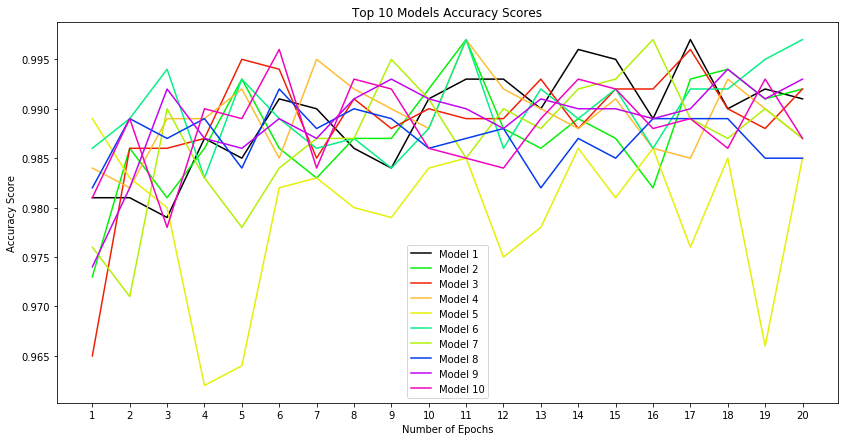

In [97]:
import numpy as np
import matplotlib.pyplot as plt

epoch_range = list(range(1, epochs+1, 1))

colors = ['#000000','#04f108', '#f11f04', '#FFBD33', '#e5f104', '#04f186', '#b2f104', '#043bf1', '#c204f1', 
          '#f104be']


fig, ax = plt.subplots(figsize=(14, 7))
plt.title("Top 10 Models Accuracy Scores")

for i in range(top_models_num):
    ax.plot(epoch_range, models_accuracies[i], colors[i], linewidth=1.5, label="Model "+str(i+1))
    
ax.legend()
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Number of Epochs")
plt.xticks(np.arange(1, epochs+1, step=1))
plt.show()

 

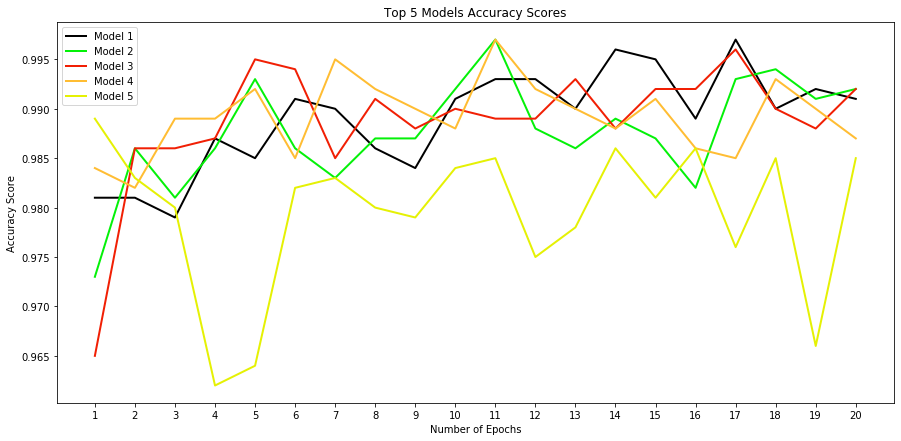

In [98]:
epoch_range = list(range(1, epochs+1, 1))

colors = ['#000000', '#04f108', '#f11f04', '#FFBD33', '#e5f104', '#04f186', '#b2f104', '#043bf1', '#c204f1', 
          '#f104be']

fig, ax = plt.subplots(figsize=(15, 7))
plt.title("Top 5 Models Accuracy Scores")

for i in range(5):
    ax.plot(epoch_range, models_accuracies[i], colors[i], linewidth=2, label="Model "+str(i+1))
    
ax.legend()
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Number of Epochs")
plt.xticks(np.arange(1, epochs+1, step=1))

plt.show()

 

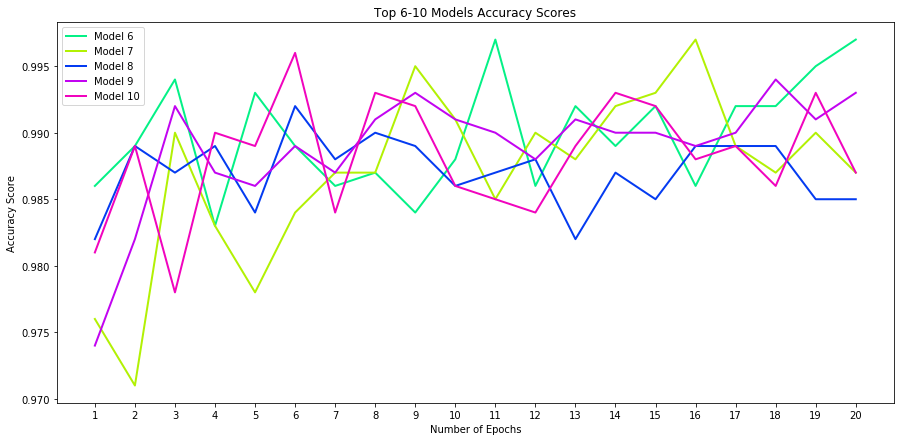

In [99]:
epoch_range = list(range(1, epochs+1, 1))

colors = ['#000000', '#04f108', '#f11f04', '#FFBD33', '#e5f104', '#04f186', '#b2f104', '#043bf1', '#c204f1', 
          '#f104be']

fig, ax = plt.subplots(figsize=(15, 7))
plt.title("Top 6-10 Models Accuracy Scores")

for i in range(5, top_models_num):
    ax.plot(epoch_range, models_accuracies[i], colors[i], linewidth=2, label="Model "+str(i+1))
    
ax.legend()
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Number of Epochs")
plt.xticks(np.arange(1, epochs+1, step=1))

plt.show()
